# Nested Hierarchical Structure with MQNLI

In this notebook, we use `pyvene` to analyze language models on a complex heirarchical task: multiply-quantified natural language inference (MQNLI). 
We begin by describing the causal structure that generates our data through semantic composition. Then, we analyze whether models that learn this task employ the same compositional structure to solve it.

In [1]:
__author__ = "Amir Zur"

## Set-Up

In [2]:
%load_ext autoreload
%autoreload 2
import pyvene

In [3]:
import os
import json 
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange
from collections import Counter

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score

from pyvene import CausalModel
# from pyvene.models.configuration_intervenable_model import RepresentationConfig
from pyvene import (
    IntervenableModel,
    RotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig
)

from pyvene.models.gpt2.modelings_intervenable_gpt2 import create_gpt2_lm
# from pyvene.models.gpt_neox.modelings_intervenable_gpt_neox import create_gpt_neox

In [4]:
TRAIN_DIR = 'mqnli_factual'
DAS_DIR = 'mqnli_das'

In [5]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## The MQNLI Task

Multiply-quantified natural language inference (MQNLI) is a variant of natural language inference (NLI) with a highly structured composition. Each datapoint is a pair of sentences, and each label is the logical relation between them (e.g., entailment, reverse entailment, no relation). Crucially, the logical relation can be computed compositionally: first compute the relation between the two sentences' nouns, then their determiners, and then combine these intermediate computations to find the relation between the sentences' noun phrases (NPs). 

In this section, we walk through the high-level causal structure of MQNLI with examples from the MQNLI dataset. We encourage first-time readers to read the original paper, [Geiger, Cases, Karttunen, and Potts (2018)](https://arxiv.org/pdf/1810.13033.pdf), before getting started.

In [6]:
# JSON files generated from adapting MQNLI codebase
# https://github.com/atticusg/MultiplyQuantifiedData

class Hashabledict(dict):
    def __hash__(self):
        return hash(frozenset(self))

with open('tutorial_data/mqnli_q_projectivity.json') as f:
    determiner_signatures = json.load(f)
    determiner_signatures = Hashabledict({
        q1: Hashabledict({
            q2: Hashabledict({
                r1: Hashabledict({
                    r2: determiner_signatures[q1][q2][r1][r2]  
                    for r2 in determiner_signatures[q1][q2][r1]
                })  
                for r1 in determiner_signatures[q1][q2]
            })
            for q2 in determiner_signatures[q1]
        })
        for q1 in determiner_signatures
    })

with open('tutorial_data/mqnli_neg_signature.json') as f:
    negation_signature = Hashabledict(json.load(f))

with open('tutorial_data/mqnli_empty_signature.json') as f:
    emptystring_signature = Hashabledict(json.load(f))

with open('tutorial_data/mqnli_cont_signature.json') as f:
    compose_contradiction_signature = Hashabledict(json.load(f))

with open('tutorial_data/mqnli_neg_cont_signature.json') as f:
    compose_neg_contradiction_signature = Hashabledict(json.load(f))

In [7]:
parents = {
    "N_P_O": [],
    "N_H_O": [],
    "N_O": ["N_P_O", "N_H_O"],
    "Adj_P_O": [],
    "Adj_H_O": [],
    "Adj_O": ["Adj_P_O", "Adj_H_O"],
    "NP_O": ["Adj_O", "N_O"],
    "Q_P_O": [],
    "Q_H_O": [],
    "Q_O": ["Q_P_O", "Q_H_O"],
    "V_P": [],
    "V_H": [],
    "V": ["V_P", "V_H"],
    "Adv_P": [],
    "Adv_H": [],
    "Adv": ["Adv_P", "Adv_H"],
    "VP": ["Adv", "V"],
    "QP_O": ["Q_O", "NP_O", "VP"],
    "Neg_P": [],
    "Neg_H": [],
    "Neg": ["Neg_P", "Neg_H"],
    "NegP": ["Neg", "QP_O"],
    "N_P_S": [],
    "N_H_S": [],
    "N_S": ["N_P_S", "N_H_S"],
    "Adj_P_S": [],
    "Adj_H_S": [],
    "Adj_S": ["Adj_P_S", "Adj_H_S"],
    "NP_S": ["Adj_S", "N_S"],
    "Q_P_S": [],
    "Q_H_S": [],
    "Q_S": ["Q_P_S", "Q_H_S"],
    "QP_S": ["Q_S", "NP_S", "NegP"]
}

In [8]:
EMPTY = ""
IND = "independence"
EQV = "equivalence"
ENT = "entails"
REV = "reverse entails"
CON = "contradiction"
ALT = "alternation"
COV = "cover"
# all possible relation values from the original paper 
# (https://arxiv.org/pdf/1810.13033.pdf)
RELATIONS = [IND, EQV, ENT, REV, CON, ALT, COV]

Q_VALUES = [
    determiner_signatures[q1][q2]
    for q1 in determiner_signatures for q2 in determiner_signatures[q1]
]

values = {
    "N_P_O": ["tree", "rock"],
    "N_H_O": ["tree", "rock"],
    "N_O": [EQV, IND],
    "Adj_P_O": ["happy", "sad", EMPTY],
    "Adj_H_O": ["happy", "sad", EMPTY],
    "Adj_O": [EQV, IND, ENT, REV],
    "NP_O": [EQV, IND, ENT, REV],
    "Q_P_O": ["some", "every"],
    "Q_H_O": ["some", "every"],
    "Q_O": Q_VALUES,
    "V_P": ["climbed", "threw"],
    "V_H": ["climbed", "threw"],
    "V": [EQV, IND],
    "Adv_P": ["energetically", "joyfully", EMPTY],
    "Adv_H": ["energetically", "joyfully", EMPTY],
    "Adv": [EQV, IND, ENT, REV],
    "VP": [EQV, IND, ENT, REV],
    "QP_O": [EQV, IND, ENT, REV],
    "Neg_P": ["not", EMPTY],
    "Neg_H": ["not", EMPTY],
    "Neg": [
        negation_signature, 
        emptystring_signature, 
        compose_contradiction_signature, 
        compose_neg_contradiction_signature
    ],
    "NegP": RELATIONS,
    "N_P_S": ["child", "dog"],
    "N_H_S": ["child", "dog"],
    "N_S": [EQV, IND],
    "Adj_P_S": ["little", "cute", EMPTY],
    "Adj_H_S": ["little", "cute", EMPTY],
    "Adj_S": [EQV, IND, ENT, REV],
    "NP_S": [EQV, IND, ENT, REV],
    "Q_P_S": ["some", "every"],
    "Q_H_S": ["some", "every"],
    "Q_S": Q_VALUES,
    "QP_S": RELATIONS
}

In [9]:
# adapted from original code for MQNLI:
# https://github.com/atticusg/MultiplyQuantifiedData/blob/master/natural_logic_model.py

def adj_merge(adj_p, adj_h):
    if adj_p == adj_h:
        return EQV
    if adj_p == EMPTY:
        return REV
    if adj_h == EMPTY:
        return ENT
    return IND

adv_merge = adj_merge

def noun_phrase(adj, noun):
    #merges a noun relation with an adjective relation
    #or a verb relation with an adverb relation
    # makes sense: if the objects are the same, then adjective's relation holds
    # otherwise, they're independent
    if noun == EQV:
        return adj
    return IND

verb_phrase = noun_phrase

def negation_merge(neg_p, neg_h):
    #merges negation
    if neg_p == neg_h and neg_p == EMPTY:
        return Hashabledict(emptystring_signature)
    if neg_p == neg_h and neg_p != EMPTY:
        return Hashabledict(negation_signature)
    if neg_p == EMPTY:
        return Hashabledict(compose_contradiction_signature)
    if neg_p != EMPTY:
        return Hashabledict(compose_neg_contradiction_signature)

negation_phrase = lambda neg, qp: neg[qp]

noun_merge = lambda n_p, n_h: EQV if n_p == n_h else IND
verb_merge = noun_merge

quantifier_merge = lambda q_p, q_h: determiner_signatures[q_p][q_h]

quantifier_phrase = lambda q, np, vp: q[np][vp]

functions = {
    "N_P_O": lambda: "tree",
    "N_H_O": lambda: "tree",
    "N_O": noun_merge,
    "Adj_P_O": lambda: "happy",
    "Adj_H_O": lambda: "happy",
    "Adj_O": adj_merge,
    "NP_O": noun_phrase,
    "Q_P_O": lambda: "some",
    "Q_H_O": lambda: "some",
    "Q_O": quantifier_merge,
    "V_P": lambda: "climbed",
    "V_H": lambda: "climbed",
    "V": verb_merge,
    "Adv_P": lambda: "energetically",
    "Adv_H": lambda: "energetically",
    "Adv": adv_merge,
    "VP": verb_phrase,
    "QP_O": quantifier_phrase,
    "Neg_P": lambda: "not",
    "Neg_H": lambda: "not",
    "Neg": negation_merge,
    "NegP": negation_phrase,
    "N_P_S": lambda: "dog",
    "N_H_S": lambda: "dog",
    "N_S": noun_merge,
    "Adj_P_S": lambda: "cute",
    "Adj_H_S": lambda: "cute",
    "Adj_S": adj_merge,
    "NP_S": noun_phrase,
    "Q_P_S": lambda: "some",
    "Q_H_S": lambda: "some",
    "Q_S": quantifier_merge,
    "QP_S": quantifier_phrase
}

In [10]:
# coordinates to display the MQNLI tree
pos = {
    "N_P_O": (32, 0.3),
    "N_H_O": (30, 0.7),
    "N_O": (31, 1.3),
    "Adj_P_O": (28, 0),
    "Adj_H_O": (26, 0.5),
    "Adj_O": (27, 1),
    "NP_O": (29, 2),
    "Q_P_O": (24, 1.3),
    "Q_H_O": (22, 1.7),
    "Q_O": (23, 2.5),
    "V_P": (21, 0),
    "V_H": (19, 0.5),
    "V": (20, 1),
    "Adv_P": (17, -0.3),
    "Adv_H": (15, 0.2),
    "Adv": (16, 0.7),
    "VP": (18, 2),
    "QP_O": (25, 3),
    "Neg_P": (13, 2.5),
    "Neg_H": (11, 3),
    "Neg": (12, 3.5),
    "NegP": (14, 4),
    "N_P_S": (9, 2.2),
    "N_H_S": (7, 2.8),
    "N_S": (8, 3.3),
    "Adj_P_S": (5, 1.5),
    "Adj_H_S": (3, 2),
    "Adj_S": (4, 2.5),
    "NP_S": (6, 4.3),
    "Q_P_S": (2, 3.2),
    "Q_H_S": (0, 3.5),
    "Q_S": (1, 4),
    "QP_S": (10, 5)
}

In [11]:
variables = list(parents.keys())  # pretty sure this preserves order?

In [12]:
mqlni_model = CausalModel(variables, values, parents, functions, pos=pos)

We begin by visualizing the high-level structure of the MQNLI task. All leaf nodes consist of text entries (e.g., Adj_P_O might be "fun", N_H_O might be "child"), with one copy corresponding to the premise sentence (P) and the other corresponding to the hypothesis (H). All other nodes take on relation values (e.g., entailment, reverse entailment, no relation), or mappings between relations (e.g., (entailment, entailment) --> no entailment).

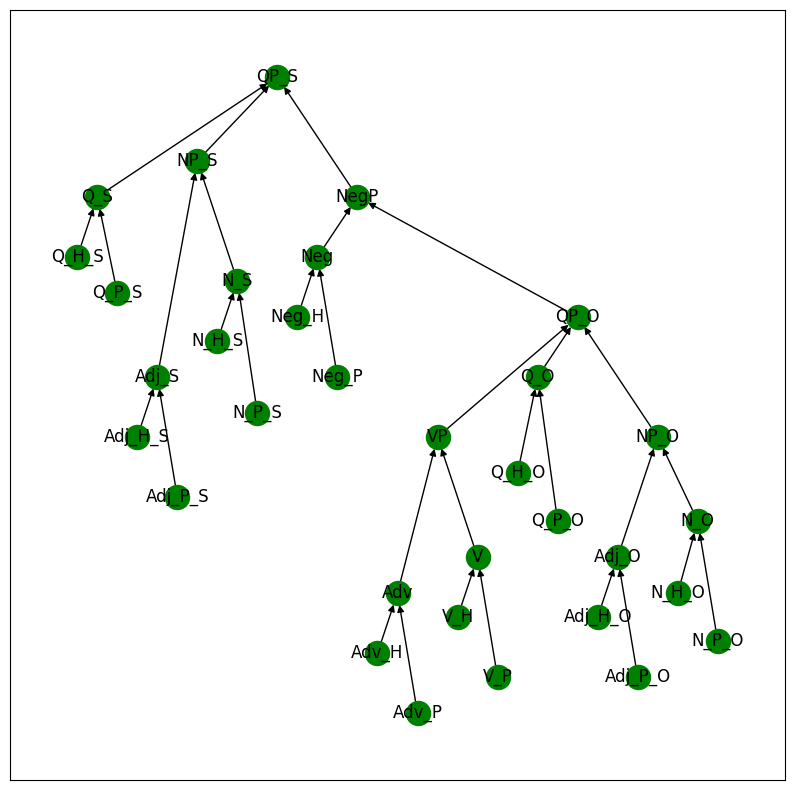

In [13]:
mqlni_model.print_structure()

### Example MQNLI Input

Here we walk through an example MQNLI input, presented below.
```json
Premise: Every dog climbed some tree.
Hypothesis: Some dog did not climb every tree.
```

The output for this sentence pair is `contradiction`, because the premise entails that there cannot be a dog who climbed no tree. 

In [14]:
inputs = {
    # premise
    "Q_P_S": "every",
    "Adj_P_S": EMPTY,
    "N_P_S": "dog",
    "Neg_P": EMPTY,
    "Adv_P": EMPTY,
    "V_P": "climbed",
    "Q_P_O": "some",
    "Adj_P_O": EMPTY,
    "N_P_O": "tree",
    # hypothesis
    "Q_H_S": "some",
    "Adj_H_S": EMPTY,
    "N_H_S": "dog",
    "Neg_H": "not",
    "Adv_H": EMPTY,
    "V_H": "climbed",
    "Q_H_O": "some",
    "Adj_H_O": EMPTY,
    "N_H_O": "tree"
}

setting = mqlni_model.run_forward(inputs)

In [15]:
def print_premise(setting):
    print(
        setting["Q_P_S"],
        setting["Adj_P_S"],
        setting["N_P_S"],
        setting["Neg_P"],
        setting["Adv_P"],
        setting["V_P"],
        setting["Q_P_O"],
        setting["Adj_P_O"],
        setting["N_P_O"]
    )

def print_hypothesis(setting):
    print(
        setting["Q_H_S"],
        setting["Adj_H_S"],
        setting["N_H_S"],
        setting["Neg_H"],
        setting["Adv_H"],
        setting["V_H"],
        setting["Q_H_O"],
        setting["Adj_H_O"],
        setting["N_H_O"]
    )

print_premise(setting)
print_hypothesis(setting)

print(setting["QP_S"]) # the output is in the root node, QP_S

every  dog   climbed some  tree
some  dog not  climbed some  tree
contradiction


We display the structure of the MQNLI example below. Note that the intermediate relation values compose with each other to produce the final output. For instance, since `N_O` and `Adj_O` both take on the value `equivalence`, then `NP_O` is also an equivalence relation.

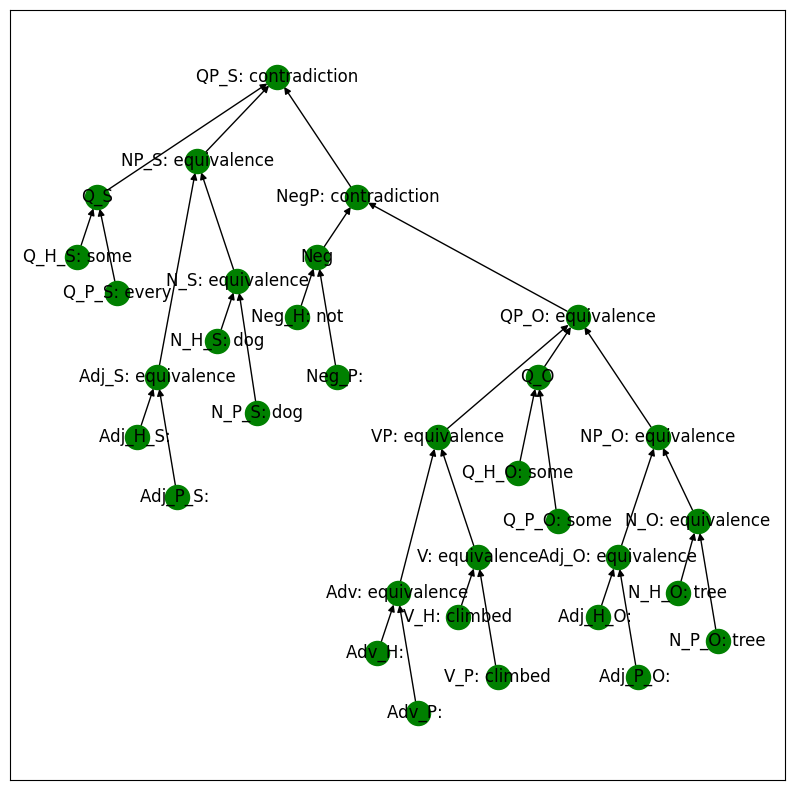

In [16]:
display = {v: not isinstance(values[v][0], dict) for v in variables}
mqlni_model.print_setting(setting, display=display)

### MQNLI with an Intervention

Below is a run of the MQNLI logic model where we intervene on the object quantifier (`QP_O`) and swap its relation value from `equivalence` to `contradiction`. Note that this changes the final output from `contradiction` to `entailment`.

every  dog   climbed some  tree
some  dog not  climbed some  tree
entails


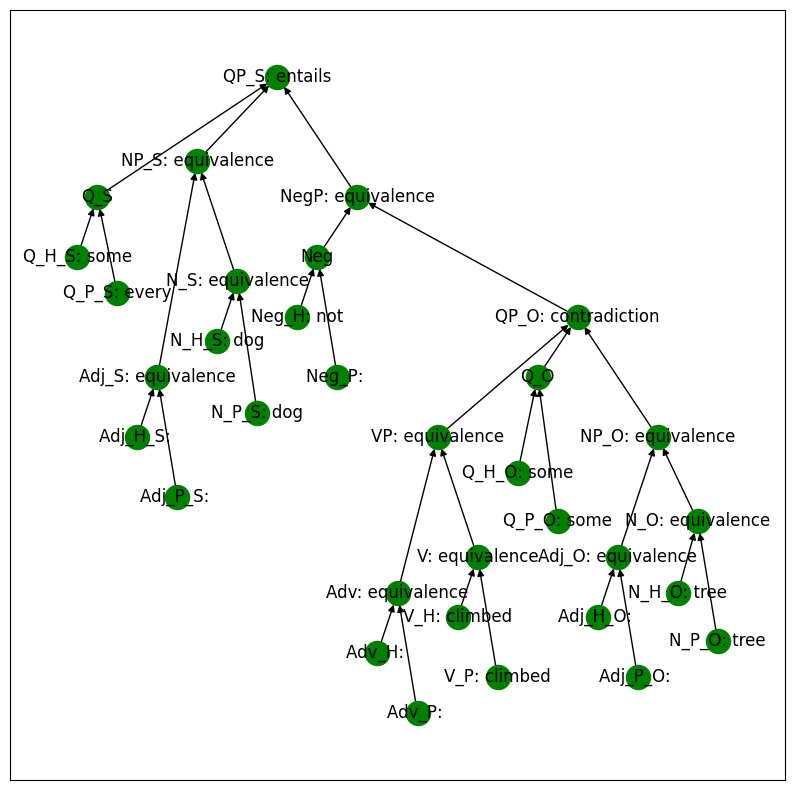

In [17]:
intervention = {**inputs, 'QP_O': 'contradiction'}
setting = mqlni_model.run_forward(intervention)
print_premise(setting)
print_hypothesis(setting)
print(setting["QP_S"])

mqlni_model.print_setting(setting, display=display)

## Training a Model on MQNLI

In this section, we train a language model (GPT-2) on the MQNLI task. Importantly, we do not need to access the original MQNLI dataset to do this -- having set up our causal model earlier in this notebook, we can generate datapoints by sampling from it directly! 

In [18]:
dataset = mqlni_model.generate_factual_dataset(100, sampler=mqlni_model.sample_input_tree_balanced, return_tensors=False)

X = [example['input_ids'] for example in dataset]
y = [example['labels'] for example in dataset]

In [19]:
i = 0

print_premise(X[i])
print_hypothesis(X[i])
print(y[i]['QP_S'])

some little child  energetically climbed some happy tree
every  child not energetically climbed some happy tree
alternation


We want to make sure that we indeed sampled evenly from the causal structure. For now, we can just verify that every possible output value (i.e., the values of the root node `QP_S`) has enough datapoints. 

In [20]:
Counter([n['QP_S'] for n in y])

Counter({'alternation': 16,
         'contradiction': 18,
         'reverse entails': 15,
         'independence': 14,
         'entails': 16,
         'equivalence': 10,
         'cover': 11})

Time to train a language model!

In [21]:
config, tokenizer, model = create_gpt2_lm()

loaded model


In [22]:
def premise_to_string(setting):
    return \
        setting["Q_P_S"] + ' ' + \
        setting["Adj_P_S"] + ' ' + \
        setting["N_P_S"] + ' ' + \
        setting["Neg_P"] + ' ' + \
        setting["Adv_P"] + ' ' + \
        setting["V_P"] + ' ' + \
        setting["Q_P_O"] + ' ' + \
        setting["Adj_P_O"] + ' ' + \
        setting["N_P_O"]

def hypothesis_to_string(setting):
    return \
        setting["Q_H_S"] + ' ' + \
        setting["Adj_H_S"] + ' ' + \
        setting["N_H_S"] + ' ' + \
        setting["Neg_H"] + ' ' + \
        setting["Adv_H"] + ' ' + \
        setting["V_H"] + ' ' + \
        setting["Q_H_O"] + ' ' + \
        setting["Adj_H_O"] + ' ' + \
        setting["N_H_O"]

def preprocess_input(setting):
    return f'Premise: {premise_to_string(setting)}\nHypothesis: {hypothesis_to_string(setting)}\nRelation: '

def preprocess_output(setting):
    return setting['QP_S']

In [23]:
IGNORE_INDEX = -100
MAX_LENGTH = 64

tokenizer.pad_token = tokenizer.eos_token

def preprocess(X, y):
    examples = [preprocess_input(x) for x in X]
    labels = [preprocess_output(y) for y in y]

    examples = tokenizer(
        examples, 
        padding='max_length', 
        max_length=MAX_LENGTH, 
        truncation=True, 
        return_tensors='pt'
    )
    labels = tokenizer(
        labels, 
        padding='max_length', 
        max_length=MAX_LENGTH, 
        truncation=True, 
        return_tensors='pt'
    )['input_ids'][:, 0] # get first token of label
    
    # put label at the last index
    examples['labels'] = torch.full_like(examples['input_ids'], IGNORE_INDEX)
    examples['labels'][:, -1] = labels

    return examples

train_dataset = preprocess(X, y)

In [31]:
# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]=TRAIN_DIR

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="false"

def accuracy_metric(x):
    labels = x.label_ids[:, -1]
    # predictions = x.predictions[0].argmax(axis=-1)[:, -2]  # uncomment for gpt-neox
    predictions = x.predictions.argmax(axis=-1)[:, -2]
    return {
        'accuracy': accuracy_score(y_true=labels, y_pred=predictions),
    }

train_ds = Dataset.from_dict(train_dataset)

batch_size = 8

training_args = TrainingArguments(
    output_dir=TRAIN_DIR,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=1e-05,
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="wandb", # optional, remove if you don't want to log to wandb
    use_cpu=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=accuracy_metric
)

Train the model and log it in a Weights & Biases run.

In [32]:
import wandb 

_ = trainer.train()

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 4.242105484008789, 'eval_accuracy': 0.17, 'eval_runtime': 12.9558, 'eval_samples_per_second': 7.719, 'eval_steps_per_second': 1.003, 'epoch': 1.0}
{'train_runtime': 52.4216, 'train_samples_per_second': 1.908, 'train_steps_per_second': 0.248, 'train_loss': 5.367249708909255, 'epoch': 1.0}


In [33]:
trainer.save_model(TRAIN_DIR)

We evaluate the model on the training dataset and a newly-sampled test dataset. The model generalizes, meaning it learned the MQNLI task!

In [34]:
tokenizer.pad_token = tokenizer.eos_token
test_examples = mqlni_model.generate_factual_dataset(100, sampler=mqlni_model.sample_input_tree_balanced, return_tensors=False)
X = [example['input_ids'] for example in test_examples]
y = [example['labels'] for example in test_examples]
test_dataset = preprocess(X, y)
test_ds = Dataset.from_dict(test_dataset)

In [35]:
results = trainer.evaluate(train_ds)
results

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 4.242105484008789,
 'eval_accuracy': 0.17,
 'eval_runtime': 12.6987,
 'eval_samples_per_second': 7.875,
 'eval_steps_per_second': 1.024,
 'epoch': 1.0}

In [36]:
results = trainer.evaluate(test_ds)
results

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 4.242105484008789,
 'eval_accuracy': 0.17,
 'eval_runtime': 12.532,
 'eval_samples_per_second': 7.98,
 'eval_steps_per_second': 1.037,
 'epoch': 1.0}

In [37]:
wandb.finish()

eval/accuracy,▁▁▁
eval/loss,▁▁▁
eval/runtime,█▄▁
eval/samples_per_second,▁▅█
eval/steps_per_second,▁▅█
train/epoch,▁▁▁▁
train/global_step,▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁


## Interpreting Our Model

In this final section, we use distributed alignment search DAS from [Geiger*, Wu*, Potts, Icard, and Goodman (2024)](https://arxiv.org/pdf/2303.02536.pdf) to find an alignment between the high-level causal structure of MQNLI and our low-level language model trained on the MQNLI dataset.

In this section, we won't search for an alignment over the entire causal structure. Instead, we will search for an alignment between the low-level model representations and the `NegP` token. Efficiently searching for a full alignment over a complex, nested causal structure is an open problem that is worth pursuing! 

In [38]:
config, tokenizer, model = create_gpt2_lm(name=TRAIN_DIR)

loaded model


Here we set up our alignment. We will search for a subspace with a dimension of 128 (a fourth of our model's hidden dimension size) in the residual stream of the 10th layer of the model (out of 12 overall transformer layers).

In [39]:
config = IntervenableConfig(
    model_type=type(model),
    representations=[
        RepresentationConfig(
            10,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=[[0, 128]], 
            # intervention_link_key=0,
        )
    ],
    intervention_types=RotatedSpaceIntervention,
)

In [40]:
intervenable = IntervenableModel(config, model, use_fast=True)
# intervenable.set_device('cuda')
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


Crucially, our interpretability experiments rely on a counterfactual dataset: for a given input, we want to consider what might happen had the value of `NegP` changed while all else remained the same. Fortunately, this is precisely what our causal model can provide us with! We can generate a counterfactual dataset by sampling inputs that only vary from each other on the `NegP` node.

In [41]:
def sample_intervention(*args, **kwargs):
    return {
        'NegP' : random.choice(mqlni_model.values['NegP'])
    }

def intervention_id(*args, **kwargs):
    return 0

batch_size = 2 # specifies how many inputs we want per intervention that is sampled

dataset = mqlni_model.generate_counterfactual_dataset(
    100, intervention_id, batch_size, 
    sampler=mqlni_model.sample_input_tree_balanced, intervention_sampler=sample_intervention, return_tensors=False
)

In [42]:
print(dataset[0]['base_labels']['QP_S'])
print(dataset[0]['labels']['QP_S'])

alternation
independence


In [44]:
# check that base labels are diverse (should be guaranteed by sampling from balanced input tree)
Counter([d['base_labels']['QP_S'] for d in dataset])

Counter({'alternation': 23,
         'reverse entails': 10,
         'cover': 15,
         'equivalence': 15,
         'contradiction': 9,
         'independence': 14,
         'entails': 14})

In [45]:
# check that counterfactuals labels are diverse (note that this could be skewed by the node's effect on the final output)
Counter([d['labels']['QP_S'] for d in dataset])

Counter({'independence': 47,
         'reverse entails': 10,
         'entails': 9,
         'alternation': 20,
         'cover': 10,
         'contradiction': 3,
         'equivalence': 1})

In [46]:
IGNORE_INDEX = -100
MAX_LENGTH = 64

tokenizer.pad_token = tokenizer.eos_token

def preprocess_input(setting):
    return f'Premise: {premise_to_string(setting)}\nHypothesis: {hypothesis_to_string(setting)}\nRelation: '

def preprocess_output(setting):
    return setting['QP_S']

def tokenize(x):
    return tokenizer(
        x, 
        padding='max_length', 
        max_length=MAX_LENGTH, 
        truncation=True, 
        return_tensors='pt'
    )

def preprocess_counterfactual(data):
    preprocessed_data = []
    for d in data:
        base = preprocess_input(d['input_ids'])
        sources = [preprocess_input(d['source_input_ids'][0])]
        label = preprocess_output(d['labels'])
        base_label = preprocess_output(d['base_labels'])

        preprocessed = {}
        preprocessed['input'] = tokenize(base)
        preprocessed['source'] = [tokenize(sources[0])]
        # place label at last index
        label = tokenize(label)['input_ids'][:, 0]
        preprocessed['label'] = torch.full_like(preprocessed['input']['input_ids'], IGNORE_INDEX)
        preprocessed['label'][:, -1] = label
        # repeat for base label
        base_label = tokenize(base_label)['input_ids'][:, 0]
        preprocessed['base_label'] = torch.full_like(preprocessed['input']['input_ids'], IGNORE_INDEX)
        preprocessed['base_label'][:, -1] = base_label
        preprocessed['intervention_id'] = torch.tensor(d['intervention_id'])
        preprocessed_data.append(preprocessed)
    return preprocessed_data

In [47]:
train_dataset = preprocess_counterfactual(dataset)

In [48]:
dataloader = DataLoader(train_dataset, batch_size=2)

Set up our optimizer, loss function, and accuracy metric.

In [49]:
epochs = 3
batch_size = 8
gradient_accumulation_steps = 1

optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=0.001)


def compute_metrics(eval_preds, eval_labels):
    accuracy = accuracy_score(
        y_pred=eval_preds[..., -2].squeeze().clone().detach().cpu().numpy(), 
        y_true=eval_labels[..., -1].squeeze().clone().detach().cpu().numpy()
    )
    return {
        "accuracy": accuracy
    }


def compute_loss(outputs, labels):
    # Shift so that tokens < n predict n
    shift_logits = outputs[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

Run DAS to find an alignment between our high-level causal model and the language model trained on MQNLI.

In [50]:
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

total_step = 0
for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            train_dataset,
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    for batch in epoch_iterator:
        inputs = {k: v.to(intervenable.get_device()) for k, v in batch['input'].items()}
        sources = [{k: v.to(intervenable.get_device()) for k, v in s.items()} for s in batch['source']]
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            {"sources->base": ([[[MAX_LENGTH - 2]] * batch_size], [[[MAX_LENGTH - 2]] * batch_size])},
            subspaces=[[[0]] * batch_size],
        )

        eval_metrics = compute_metrics(
            counterfactual_outputs.logits.argmax(-1), batch["label"].to(intervenable.get_device())
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, batch["label"].to(intervenable.get_device())
        )

        epoch_iterator.set_postfix({"loss": loss.item(), "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  589824



Epoch: 0: 100%|██████████| 12/12 [00:59<00:00,  4.93s/it, loss=6.88, acc=0]    

Epoch: 1: 100%|██████████| 12/12 [00:58<00:00,  4.91s/it, loss=5.86, acc=0]   

Epoch: 2: 100%|██████████| 12/12 [00:59<00:00,  4.98s/it, loss=6.37, acc=0]    

Epoch: 100%|██████████| 3/3 [02:57<00:00, 59.28s/it]


In [51]:
intervenable.save(DAS_DIR)

Directory 'mqnli_das' already exists.


### Evaluate DAS Alignment

Lastly, we evaluate the accuracy of the alignment found by DAS. 

In [52]:
config, tokenizer, model = create_gpt2_lm(name=TRAIN_DIR)
intervenable = IntervenableModel.load(DAS_DIR, model)

loaded model


First, we evaluate the model's performance on the MQNLI factual task. As before, we expect our model to complete this task with nearly perfect accuracy.

In [53]:
tokenizer.pad_token = tokenizer.eos_token
examples = mqlni_model.generate_factual_dataset(100, sampler=mqlni_model.sample_input_tree_balanced, return_tensors=False)
X = [example['input_ids'] for example in examples]
y = [example['labels'] for example in examples]
test_factual_dataset = preprocess(X, y)

In [54]:
def accuracy_metric(x):
    labels = x.label_ids[:, -1]
    # predictions = x.predictions[0].argmax(axis=-1)[:, -2]  # take one index before label
    predictions = x.predictions.argmax(axis=-1)[:, -2]
    return {
        'accuracy': accuracy_score(y_true=labels, y_pred=predictions),
    }

test_factual_ds = Dataset.from_dict(test_factual_dataset)

batch_size = 8

training_args = TrainingArguments(
    output_dir="test_mqnli_trainer",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=1e-05,
    num_train_epochs=1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    report_to="none",
    use_cpu=True,
)

trainer = Trainer(
    model=intervenable.model,
    args=training_args,
    compute_metrics=accuracy_metric
)

In [55]:
trainer.evaluate(test_factual_ds)

  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 4.302060127258301,
 'eval_accuracy': 0.17,
 'eval_runtime': 18.8671,
 'eval_samples_per_second': 5.3,
 'eval_steps_per_second': 0.689}

Next, we evaluate the DAS alignment on a newly-sampled counterfactual dataset. If our alignment generalizes, then we should expect a high interchange intervention accuracy (IIA) on the counterfactual dataset. We compute IIA by comparing the model's output with an interchange-intervention to the causal model's output with that same intervention applied to its high-level variables (i.e., we verify that an intervention changes the model's output in the direction that our causal model predicts). 

In [56]:
batch_size = 8

dataset = mqlni_model.generate_counterfactual_dataset(
    1000, intervention_id, 1, 
    sampler=mqlni_model.sample_input_tree_balanced, intervention_sampler=sample_intervention, return_tensors=False
)

In [58]:
test_cf_dataset = preprocess_counterfactual(dataset)

In [59]:
def compute_metrics(eval_preds, eval_labels):
    accuracy = accuracy_score(
        y_pred=eval_preds[..., -2].squeeze().clone().detach().cpu().numpy(), 
        y_true=eval_labels[..., -1].squeeze().clone().detach().cpu().numpy()
    )
    return {
        "accuracy": accuracy
    }

In [ ]:
intervenable.set_device('cuda')
# intervenable.disable_intervention_gradients()
# intervenable.disable_model_gradients()
# intervenable.model.eval()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())

base_labels = None
counterfactual_labels = None
base_preds = None
counterfactual_preds = None

batch_size = 8

with torch.no_grad():
    for batch in tqdm(DataLoader(
        test_cf_dataset,
        batch_size=batch_size,
        drop_last=True
    )):
        inputs = {k: v.to(intervenable.get_device()) for k, v in batch['input'].items()}
        sources = [{k: v.to(intervenable.get_device()) for k, v in s.items()} for s in batch['source']]
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            {"sources->base": ([[[MAX_LENGTH - 2]] * batch_size], [[[MAX_LENGTH - 2]] * batch_size])},
            subspaces=[[[0]] * batch_size],
        )

        if base_labels is None:
            # base_preds = base_outputs.logits.argmax(-1).clone().detach()
            # base_labels = batch['base_label']
            counterfactual_preds = counterfactual_outputs.logits.argmax(-1).clone().detach()
            counterfactual_labels = batch['label']
        else:
            # base_preds = torch.cat((base_preds, base_outputs.logits.argmax(-1).clone().detach()))
            # base_labels = torch.cat((base_labels, batch['base_label']))
            counterfactual_preds = torch.cat((counterfactual_preds, counterfactual_outputs.logits.argmax(-1).clone().detach()))
            counterfactual_labels = torch.cat((counterfactual_labels, batch['label']))

In [63]:
{
    # 'base_accuracy': compute_metrics(base_preds, base_labels)['accuracy'],
    'counterfactual_accuracy': compute_metrics(counterfactual_preds, counterfactual_labels)['accuracy']
}

{'counterfactual_accuracy': 0.125}